In [1]:
from src import database
from src import pipeline
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

### Überblick über die Daten

In [2]:
df = database.database_raw()
print(df.info())
print(df.dtypes.value_counts())
print(df.isnull().sum().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8825 entries, 0 to 8824
Columns: 993 entries, Stücknummer to PRODCT_EFFECTIVE_M2_WEIGHT
dtypes: Int32(17), datetime64[ns](45), float64(124), int32(263), object(544)
memory usage: 57.6+ MB
None
object            544
int32             263
float64           124
datetime64[ns]     45
Int32              17
dtype: int64
3245140


### Heimbach Features

In [6]:
# Überprüfen Sie die Existenz der ausgewählten Spalten im DataFrame, da beim Preprocessing Spalten entfernt wurden in df_preprocessed
heimbach_features = [col for col in database.get_heimbach_important_features() if col in df.columns]
df_heimbach= df[heimbach_features]
print(df.shape)
print(df_heimbach.dtypes.value_counts())
print(heimbach_features)
print(len(heimbach_features))

### In der Vorverarbeitung werden EA Fixiervorschrift und MDS Flächengewicht entfernt, weil:
removed_features = ["EA Fixiervorschrift", "MDS Flächengewicht"]  

for feature in removed_features:
    unique_values = df[feature].nunique()
    print(f"{feature}: {unique_values} einzigartige Werte")
    
for feature in removed_features:
    nan_percentage = df[feature].isna().mean() * 100
    print(f"{feature}: {nan_percentage:.2f}% fehlende Werte")

(8825, 993)
object     14
int32      10
float64     7
Int32       1
dtype: int64
['Stücknummer', 'Produktgruppe Vertrieb', 'Träger', 'Auflage', 'Benadelungstechnik', 'Oberflächenbehandlung', 'Zweckbehandlung', 'NA Einstiche pro cm2', 'EA Fixiervorschrift', 'Auflage Gewicht sum.', 'SD Soll-Länge', 'SD Soll-Breite', 'MDS Flächengewicht', 'PF Flächengewicht', 'PF Flächengew. Type', 'NA LD', 'NA LD Typenstamm', 'NA Dicke', 'NA Dicke Soll', 'EA LD Textest', 'EA LD Text.Typenst.', 'SD Debitor', 'SD Suchbegriff 1 K.', 'SD Maschinenbez.', 'SD Einsatzst.-bez.', 'NA Kerbentiefe', 'Aktive Oberfläche', 'EA Abw Länge Soll', 'EA Fixierspannung', 'EA Breite n. Schm.', 'Nadelvorschrift', 'FELT_LIFE_NET']
32
EA Fixiervorschrift: 18 einzigartige Werte
MDS Flächengewicht: 1 einzigartige Werte
EA Fixiervorschrift: 44.73% fehlende Werte
MDS Flächengewicht: 0.00% fehlende Werte


### Zusammenhang zwischen FELT_LIFE_NET und 'INSTALLATION_DATE','REPORT_DATE','REMOVAL_DATE'

In [5]:
# Eine Kopie des DataFrames erstellen
df_copy = df.copy()

# Datumswerte in datetime-Format umwandeln
df_copy['INSTALLATION_DATE'] = pd.to_datetime(df_copy['INSTALLATION_DATE'])
df_copy['REMOVAL_DATE'] = pd.to_datetime(df_copy['REMOVAL_DATE'])

# Differenz zwischen REMOVAL_DATE und INSTALLATION_DATE berechnen (in Tagen)
df_copy['CALCULATED_LIFE_DAYS'] = (df_copy['REMOVAL_DATE'] - df_copy['INSTALLATION_DATE']).dt.days

# Vergleich mit FELT_LIFE_NET
df_copy['MATCHES_FELT_LIFE_NET'] = df_copy['CALCULATED_LIFE_DAYS'] == df_copy['FELT_LIFE_NET']

# Kopie anzeigen
print(df_copy[['FELT_LIFE_NET', 'INSTALLATION_DATE', 'REMOVAL_DATE', 'CALCULATED_LIFE_DAYS', 'MATCHES_FELT_LIFE_NET']])

      FELT_LIFE_NET INSTALLATION_DATE REMOVAL_DATE  CALCULATED_LIFE_DAYS  \
0             141.0        2013-01-15   2013-06-05                 141.0   
1              28.0        2013-08-06   2013-09-03                  28.0   
2              49.0        2013-06-18   2013-08-06                  49.0   
3              42.0        2013-06-27   2013-08-08                  42.0   
4              30.0        2013-05-31   2013-06-30                  30.0   
...             ...               ...          ...                   ...   
8820           57.0        2013-03-06   2013-05-02                  57.0   
8821           74.0        2013-02-27   2013-05-12                  74.0   
8822           36.0        2009-10-14   2009-11-19                  36.0   
8823           27.0        2010-01-01   2010-01-28                  27.0   
8824           22.0        2010-04-07   2010-04-29                  22.0   

      MATCHES_FELT_LIFE_NET  
0                      True  
1                      True

## Die Zielvariable FELT_LIFE_NET

In [9]:
print(df['FELT_LIFE_NET'].describe())

count    8796.000000
mean       60.404502
std        70.179496
min         0.000000
25%        28.000000
50%        41.000000
75%        64.000000
max      1102.000000
Name: FELT_LIFE_NET, dtype: float64


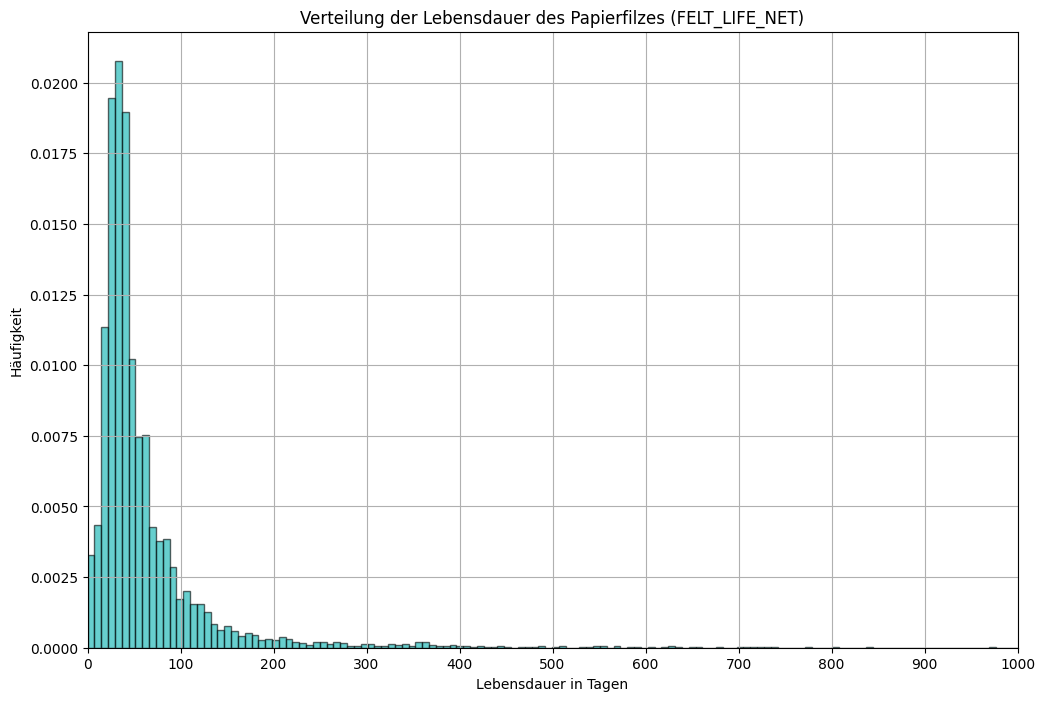

In [10]:
label = df['FELT_LIFE_NET']


plt.figure(figsize=(12, 8))
plt.hist(label, bins=150, color='#02b0ae', edgecolor='black',density=True, alpha=0.6,)
# Definiere die gewünschten Schritte für die x-Achse und generiere die Werte
x_ticks = np.arange(0, 1001, 100)  # Von 0 bis 10 in 1er Schritten
# Passe die x-Achse an
plt.xticks(x_ticks)
plt.xlim(0, 1000)
plt.xlabel('Lebensdauer in Tagen')
plt.ylabel('Häufigkeit')
plt.title('Verteilung der Lebensdauer des Papierfilzes (FELT_LIFE_NET)')
plt.grid(True)
plt.show()

## Erste Vorverarbeitung:

### NaN Threshold Graph

(8825, 790)


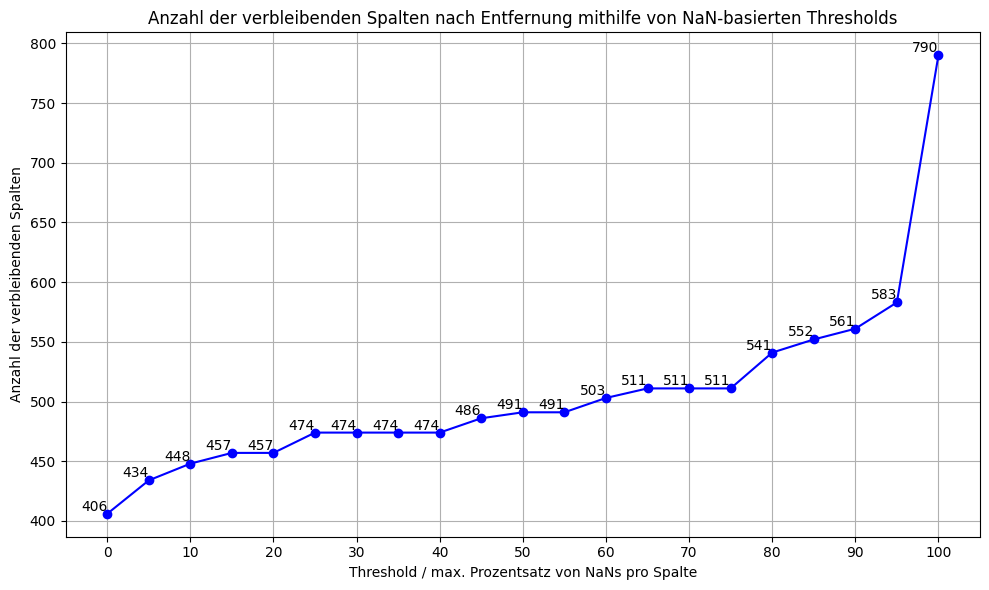

In [11]:
df = database.database_raw()

# Entferne Spalten mit konstantem Wert
df = df.loc[:, df.nunique() != 1]

print(df.shape)
thresholds = range(0, 101, 5)

# Liste zur Speicherung der Anzahl der verbleibenden Spalten für jeden Threshold-Wert
remaining_columns = []

# Iteriere über die Threshold-Werte und zähle die Anzahl der Spalten, die entfernt würden
for threshold in thresholds:
    # Berechne den Prozentsatz NaNs für jede Spalte
    nan_percentage = df.isna().mean() * 100
    
    # Zähle die Anzahl der Spalten, die mehr NaNs als den aktuellen Threshold haben
    columns_to_drop = (nan_percentage > threshold).sum()
    
    # Berechne die Anzahl der verbleibenden Spalten
    remaining_columns.append(len(df.columns) - columns_to_drop)
    
# Plotte die Ergebnisse
plt.figure(figsize=(10, 6))
plt.plot(thresholds, remaining_columns, marker='o', linestyle='-', color='b')
plt.title('Anzahl der verbleibenden Spalten nach Entfernung mithilfe von NaN-basierten Thresholds')
plt.xlabel('Threshold / max. Prozentsatz von NaNs pro Spalte')
plt.ylabel('Anzahl der verbleibenden Spalten')
plt.grid(True)
plt.xticks(range(0, 101, 10))
plt.tight_layout()

# Füge die genaue Anzahl der verbleibenden Spalten als Text neben jedem Punkt hinzu
for x, y in zip(thresholds, remaining_columns):
    plt.text(x, y, f'{y}', ha='right', va='bottom')

plt.show()

### Erste Pipeline

In [2]:
df = database.database_raw()

pipeline_raw = Pipeline([
    ('SameValuesColumnRemover', pipeline.SameValuesColumnRemover(nan_threshold=0.25)),
    ('CleanFeatureNamesTransformer', pipeline.CleanFeatureNamesTransformer()),
    ('DropNaNsInColumn', pipeline.DropNaNsInColumn(column_name="FELT_LIFE_NET")),
    ('SimilarityCalculator', pipeline.SimilarityCalculator(col1='FELT_LIFE_NET', col2='FELT_LIFE')),
    #('RemoveColumns', pipeline.RemoveColumns(column_names=['FELT_LIFE','REMOVAL_DATE', 'INSTALLATION_DATE', 'REPORT_DATE']))
])

# Überprüfe jede Zeile auf NaN-Werte und zähle die Anzahl
anzahl_nan_zeilen = df.isnull().any(axis=1).sum()

# Berechne den Prozentsatz
prozentsatz_nan_zeilen = (anzahl_nan_zeilen / len(df)) * 100

print(f"In {prozentsatz_nan_zeilen:.2f}% der Zeilen gibt es mindestens einen NaN-Wert.")

# Pipeline anwenden
df_raw = pipeline_raw.fit_transform(df)




print(df_raw.shape)

numerical_features, categorical_features, date_features = pipeline.einteilen_merkmale(df_raw)
print("Kategorischen Features nach 1. Pipeline: ", len(categorical_features))
print("Numerische Features nach 1. Pipeline: ", len(numerical_features))
print("Datum-Features nach 1. Pipeline: ", len(date_features))

In 100.00% der Zeilen gibt es mindestens einen NaN-Wert.
Anzahl der entfernten NaN-Werte in Spalte 'FELT_LIFE_NET': 29
Durchschnittliche Übereinstimmung zwischen FELT_LIFE_NET und FELT_LIFE: 99.94998551560724%
(8796, 474)
Kategorischen Features nach 1. Pipeline:  148
Numerische Features nach 1. Pipeline:  312
Datum-Features nach 1. Pipeline:  14


## Zweite Vorverarbeitung

In [3]:
unique_counts = df_raw[categorical_features].nunique()
average_unique_categories = unique_counts.mean()
print(f"Durchschnittliche Anzahl unterschiedlicher Kategorien: {average_unique_categories:.2f}")
# Finde die Spalte mit den meisten und den wenigsten einzigartigen Werten
max_unique_col = unique_counts.idxmax()
min_unique_col = unique_counts.idxmin()

max_unique_count = unique_counts.max()
min_unique_count = unique_counts.min()

# Ausgabe der Ergebnisse
print(f"Spalte mit den meisten einzigartigen Werten: {max_unique_col} ({max_unique_count} Werte)")
print(f"Spalte mit den wenigsten einzigartigen Werten: {min_unique_col} ({min_unique_count} Werte)")

# Berechne die Quantile (z.B. 25%, 50%, 75%)
quantiles = unique_counts.quantile([0.25, 0.5, 0.75])
print("\nQuantile der Anzahl einzigartiger Werte:")
print(quantiles)

Durchschnittliche Anzahl unterschiedlicher Kategorien: 840.46
Spalte mit den meisten einzigartigen Werten: Stücknummer (8788 Werte)
Spalte mit den wenigsten einzigartigen Werten: AT1 Versionsnummer (2 Werte)

Quantile der Anzahl einzigartiger Werte:
0.25     3.00
0.50     9.00
0.75    35.25
dtype: float64


In [4]:
categorical_df = df_raw[categorical_features]

y = df_raw["FELT_LIFE_NET"]

pipeline_categorical = Pipeline([
   ('MissingRowsCounter', pipeline. MissingRowsCounter()),
   ('CategoricalModeImputer', pipeline. CategoricalModeImputer()),
])
cat_prep = pipeline_categorical.fit_transform(categorical_df)

cat_prep = pipeline.HybridEncoder().transform(cat_prep, y)

Prozentsatz der Zeilen, die gedroppt würden, wenn keine Imputation stattfindet: 17.974079126875854 %
148 Merkmale wurden encodet.


In [5]:
date_df = df_raw[date_features]

pipeline_date = Pipeline([
   ('MissingRowsCounter', pipeline. MissingRowsCounter()),
   ('DateTimePreprocessor', pipeline. DateTimePreprocessor(fill_method='ffill'))
])

date_prep = pipeline_date.fit_transform(date_df)

Prozentsatz der Zeilen, die gedroppt würden, wenn keine Imputation stattfindet: 27.47839927239654 %


In [6]:
numeric_df = df_raw[numerical_features]
numeric_df = pd.DataFrame(numeric_df.drop("FELT_LIFE_NET", axis=1))
y = df_raw["FELT_LIFE_NET"].copy()

pipeline_numeric = Pipeline([
    ('MissingRowsCounter', pipeline. MissingRowsCounter()),
    ('ImputerTransformer', pipeline.ImputerTransformer(strategy='median')),
])
numeric_prep = pipeline_numeric.fit_transform(numeric_df)

Prozentsatz der Zeilen, die gedroppt würden, wenn keine Imputation stattfindet: 25.818553888130968 %
Imputation : Laufzeit der Imputation: 0.2523 Sekunden
------------------------


In [7]:
cat_prep.reset_index(drop=True, inplace=True)
date_prep.reset_index(drop=True, inplace=True)
numeric_prep.reset_index(drop=True, inplace=True)
df_combined = pd.concat([cat_prep,date_prep,numeric_prep], axis=1)

pipeline = Pipeline([
    ('RobustScalerTransformer', pipeline.RobustScalerTransformer()),
    ('PowerTransformerCustom', pipeline.PowerTransformerCustom())
   
])
df_combined_prep = pipeline.fit_transform(df_combined)

Skalierung: Laufzeit der Skalierung: 0.2398 Sekunden
------------------------
Transformation: Laufzeit der Yeo-Johnson-Transformation: 4.4719 Sekunden
------------------------


In [8]:
df = df_combined_prep
# Maximal- und Minimalwert in Spalten finden
max_value = df.max().max()  # Globaler Maximalwert
min_value = df.min().min()  # Globaler Minimalwert

max_columns = df.columns[df.max() == max_value].tolist()
min_columns = df.columns[df.min() == min_value].tolist()

# Spalten mit konstantem Wert finden
constant_columns = df.columns[df.nunique() == 1].tolist()

# Ergebnisse anzeigen
print("Globaler Maximalwert:", max_value, "in Spalten:", max_columns)
print("Globaler Minimalwert:", min_value, "in Spalten:", min_columns)
print("Spalten mit konstantem Wert:", constant_columns)

Globaler Maximalwert: 93.78166132032426 in Spalten: ['BM4 Länge']
Globaler Minimalwert: -66.3098786004016 in Spalten: ['EA Z-Status']
Spalten mit konstantem Wert: []


In [9]:
y.reset_index(drop=True, inplace=True)
df_final = pd.concat([df_combined_prep,y], axis=1)
print(df_final.shape)

(8796, 474)


In [10]:
df_final.to_csv('data/df_preprocessed_all.csv', index=False)  # Mit index=False, um den Index nicht in die CSV-Datei zu schreiben